In [1]:
import cv2
import numpy as np
from skimage import img_as_float
from scipy.ndimage import convolve, gaussian_gradient_magnitude
from numpy import asarray
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
import scipy.ndimage.filters as flt
import warnings
from scipy.spatial.distance import cdist

In [2]:
def prepare_image_inpainting(image_path, region_top_left, region_bottom_right):
    """
    Prepares an image for inpainting with a General Regression Neural Network (GRNN).

    Args:
    - image_path (str): The file path to the input image.
    - region_top_left (tuple): The (x, y) coordinates 
       of the top-left corner of the inpainting region.
    - region_bottom_right (tuple): The (x, y) coordinates of the bottom-right corner of the inpainting region.

    Returns:
    - known_region (np.array): The part of the image outside the inpainting region.
    - mask (np.array): The binary mask of the inpainting region.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or path is incorrect")

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define the mask
    mask = np.zeros(gray_image.shape, dtype="uint8")
    cv2.rectangle(mask, region_top_left, region_bottom_right, 255, -1)

    # Mask the image to separate the inpainting region
    known_region = cv2.bitwise_and(gray_image, gray_image, mask=cv2.bitwise_not(mask))
    
    return known_region, mask

# Replace 'path_to_your_image.jpg' with the path of the image you've uploaded
image_path = r'C:\Users\VIET HOANG - VTS\Desktop\testdata\main_large.jpg'
image = cv2.imread(image_path)

# Select an arbitrary region to inpaint. You can adjust these coordinates as needed.
region_top_left = (100, 100)
region_bottom_right = (250, 250)
known_region, mask = prepare_image_inpainting(image_path, region_top_left, region_bottom_right)
# Save or display the result, here's an example to save the output images
cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\known_region1.jpg', known_region)
cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\mask1.jpg', mask)

True

In [3]:
def get_coordinates(mask):
    """
    Retrieves the coordinates where a mask is non-zero.

    Args:
        mask (numpy.ndarray or list): The binary mask.

    Returns:
        list of tuple: List of (x, y) coordinates where the mask is non-zero.
    """
    if isinstance(mask, np.ndarray):
        # Check if the mask is a NumPy array
        y_coords, x_coords = np.where(mask != 0)
    else:
        # Assume the mask is a list
        y_coords, x_coords = zip(*mask)

    coordinates = list(zip(x_coords, y_coords))
    return coordinates

In [4]:
def anisotropic_diffusion(img, niter=10, kappa=50, gamma=0.1, voxelspacing=None, option=1):
    """
    Anisotropic diffusion.

    Args:
        img (ndarray): Grayscale input image.
        niter (int): Number of iterations.
        kappa (float): Conduction coefficient, controls the diffusion speed.
        gamma (float): The step size.
        voxelspacing (tuple of floats): The voxel spacing in each dimension.
        option (int): Whether to use the improved option (1 or 2).

    Returns:
        img (ndarray): Diffused image.
    """
    if img.ndim == 3:
        raise NotImplementedError("3D images are not supported yet.")

    # initialize output array
    img = img.astype('float32')

    if voxelspacing is not None:
        voxelspacing = np.asanyarray(voxelspacing, dtype='float32')
        gamma = gamma / (np.prod(voxelspacing) ** (1./3.))

    # initialize some internal variables
    deltaS = np.zeros_like(img)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(img)
    gE = gS.copy()

    for i in range(niter):

        # calculate the gradients
        deltaS[:-1, :] = np.diff(img, axis=0)
        deltaE[:, :-1] = np.diff(img, axis=1)

        if option == 1:
            gS = np.exp(-(deltaS/kappa)**2.)
            gE = np.exp(-(deltaE/kappa)**2.)
        elif option == 2:
            gS = 1./(1.+(deltaS/kappa)**2.)
            gE = 1./(1.+(deltaE/kappa)**2.)

        # update matrices
        E = gE*deltaE
        S = gS*deltaS

        # subtract a copy that has been shifted 'North/West' by one pixel
        NS[:] = S
        EW[:] = E
        NS[1:, :] -= S[:-1, :]
        EW[:, 1:] -= E[:, :-1]

        # update the image
        img += gamma*(NS+EW)

    return img.astype(np.uint8)

# Load the image
image_path = r'C:\Users\VIET HOANG - VTS\Desktop\testdata\main_large.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Validate the image is loaded
if image is None:
    raise ValueError("Image not found or path is incorrect")

# Apply anisotropic diffusion
diffused_image = anisotropic_diffusion(image)



# Save the result
cv2.imwrite(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\diffused_image1.jpg', diffused_image)
n_image=cv2.imread(r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\diffused_image1.jpg')

In [5]:
import cv2
import numpy as np

def identify_and_sort_regions_by_area_descending(image_path, threshold=1):
    """
    Identify regions in an image, calculate their areas, and sort them from largest to smallest by area.

    Args:
        image_path (str): Path to the image file.
        threshold (int): Pixel intensity threshold to identify regions. Pixels darker than this are considered part of a region.

    Returns:
        L (list of tuples): Each tuple contains (mask, area) of a region, sorted from largest to smallest by area.
    """
    # Load the image in grayscale to simplify processing
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("Image not loaded. Please check the file path and ensure the file exists.")

    # Create a binary image where the regions are highlighted
    _, binary = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)

    # Detect all contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # List to hold the area and mask of each region
    regions_with_area = []
    for contour in contours:
        # Create a mask for the current contour
        mask = np.zeros_like(img, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        
        # Calculate the area of the contour
        area = cv2.contourArea(contour)
        regions_with_area.append((mask, area))

    # Sort the list of regions by area in descending order
    L = sorted(regions_with_area, key=lambda x: x[1], reverse=True)

    return L

# Example usage:
image_path = r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\known_region1.jpg"
try:
    ordered_list = identify_and_sort_regions_by_area_descending(image_path)
    print("Regions sorted from largest to smallest by area:")
    for mask, area in ordered_list:
        print(f"Area: {area}")
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print("An error occurred:", e)

print(ordered_list)
print(len(ordered_list))

Regions sorted from largest to smallest by area:
Area: 22473.5
[(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 22473.5)]
1


In [6]:
def check_missing_regions_list(L):
    """
    Check if the list of sorted missing regions is empty and return the appropriate status.

    Args:
        L (list): List of tuples, each containing a mask of a region and its area, sorted by area.

    Returns:
        status (str): A message indicating whether the inpainting process should continue or is complete.
    """
    if not L:  # Check if the list is empty
        return False
    else:
        return True
    
check_missing_regions_list(ordered_list)

True

In [7]:
def custom_dilate_smallest_region(L, structuring_element):
    kernel = np.ones((5, 5), np.uint8)
    smallest_region = L[-1][0]
    dilated_region = cv2.dilate(smallest_region, kernel, iterations=50)

    for i in range(dilated_region.shape[0]):
      for j in range (dilated_region.shape[1]):
        if (dilated_region[i][j] == smallest_region[i][j]):
          dilated_region[i][j] =  0

    return dilated_region,smallest_region

# Example usage:
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilated_mask,smallest_region = custom_dilate_smallest_region(ordered_list, structuring_element)
if dilated_mask is not None:
    print("Dilation applied to the smallest region.")
else:
    print("Failed to apply dilation.")

    

print("Smallest=" ,smallest_region)

Dilation applied to the smallest region.
Smallest= [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
def visualize_mask(mask, title):
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

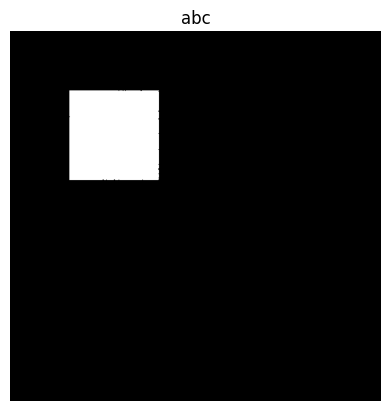

In [9]:
visualize_mask(smallest_region,"abc")

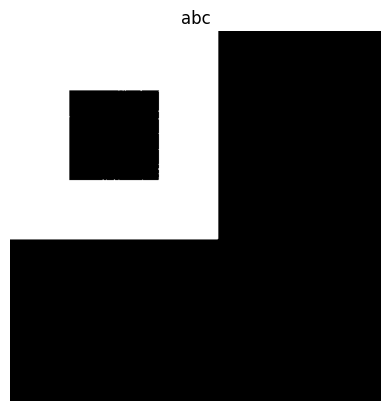

In [10]:
visualize_mask(dilated_mask,"abc")

In [11]:
def crop_corresponding_area(original_image, dilated_region_mask):
    """
    Crops the area from the original image corresponding to the dilated region mask.
    
    Args:
        original_image (np.ndarray): The original image.
        dilated_region_mask (np.ndarray): The binary mask of the dilated region.
    
    Returns:
        np.ndarray: The cropped area from the original image, or None if no contours are found.
    """
    # Validate the inputs
    if original_image is None or dilated_region_mask is None:
        raise ValueError("Original image and dilated region mask must not be None.")
    if original_image.shape[:2] != dilated_region_mask.shape:
        raise ValueError("Original image and dilated region mask must be the same size.")

    # Find contours in the dilated region mask
    contours, _ = cv2.findContours(dilated_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if not contours:
        print("No contours found in the dilated region mask.")
        return None

    # In case of multiple contours, find the largest one which should correspond to the region of interest
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding box coordinates around the dilated region
    x, y, w, h = cv2.boundingRect(largest_contour)
        
    # Crop the corresponding area from the original image, ensuring we don't go out of bounds
    cropped_image = original_image[max(y, 0):min(y+h, original_image.shape[0]), 
                                   max(x, 0):min(x+w, original_image.shape[1])]
    
    return cropped_image

In [12]:
crop_image=crop_corresponding_area(image,smallest_region)
print(crop_image)
crop_image_path = r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\crop4.jpg'
crop_image1 = cv2.imwrite(crop_image_path,crop_image)


[[ 91  93  96 ... 140 136 134]
 [ 91  92  95 ... 140 136 132]
 [ 91  92  94 ... 137 135 134]
 ...
 [ 88  89  89 ...  74  80  79]
 [ 88  89  89 ...  80  82  79]
 [ 88  89  90 ...  78  73  68]]


In [13]:



def find_optimal_spread(image):
    """
    Finds the optimal spread parameter using the given image.

    Args:
        image (numpy.ndarray): The input image.

    Returns:
        float: The optimal spread parameter (σ).
    """
    # Apply anisotropic diffusion smoothing to the image
    

    # Compute gradients in x and y directions
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the magnitude of the gradients
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)

    # Find the maximum magnitude of the gradients
    max_gradient_magnitude = np.max(gradient_magnitude)

    # Calculate the optimal spread parameter (σ)
    rho = max_gradient_magnitude
    sigma = np.exp(1 - rho / 255)

    return sigma

image_path = r'C:\Users\VIET HOANG - VTS\Desktop\testoutput\crop4.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    raise ValueError("Image not found or path is incorrect")

# Find the optimal spread parameter
sigma = find_optimal_spread(image)

print("Optimal Spread Parameter (σ):", sigma)

Optimal Spread Parameter (σ): 0.421679970897244


In [14]:
def create_training_data(inpainting_mask, target_image):
    """
    Creates a training dataset for neural network inpainting, where each pixel within the region Ω is
    paired with its corresponding intensity value from the image I′.

    Args:
        inpainting_mask (np.ndarray): Binary mask with non-zero pixels indicating region Ω.
        target_image (np.ndarray): Image I′ from which the true pixel values are known.

    Returns:
        np.ndarray: Pixel coordinates from region Ω as training features.
        np.ndarray: Corresponding pixel intensities from I′ as target outputs.
    """

    # Ensure mask and image dimensions match
    assert inpainting_mask.shape == target_image.shape, "Dimensions of mask and image must match."

    # Convert mask to boolean array if not already
    inpainting_region = inpainting_mask.astype(bool)

    # Convert target image to grayscale if it's not already
    if target_image.ndim == 3:
        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)

    # Get coordinates of pixels within the inpainting region
    coords = np.column_stack(np.where(inpainting_region))

    # Get corresponding pixel values from the target image
    pixel_values = target_image[inpainting_region]

    return coords, pixel_values.reshape(-1, 1)

# Usage example

inpainting_mask = dilated_mask
# Example usage
try:
    # Load the target image
    target_image_path = r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\diffused_image1.jpg"
    target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)
    if target_image is None:
        raise FileNotFoundError(f"Target image not found at {target_image_path}")

    # Assume 'inpainting_mask' is defined elsewhere in your code and properly loaded
    # Create the training dataset
    X_train, y_train = create_training_data(inpainting_mask, target_image)
    print(f"Training dataset created with {X_train.shape[0]} samples.")
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {str(e)}")


Training dataset created with 100426 samples.


In [15]:
print(dilated_mask)

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [16]:
class OptimizedGRNN:
    def __init__(self, sigma=None):
        self.sigma = sigma
        self.training_set = None
        self.target_values = None

    def fit(self, features, targets):
        """ Fit the GRNN model with training features and target values. """
        self.training_set = features
        self.target_values = targets
        # Estimate sigma using the median heuristic if not provided
        if self.sigma is None:
            self.sigma = np.median(cdist(features, features)) / np.sqrt(2)

    def predict(self, features, batch_size=5):
        """ Predict using the GRNN model over the input features with batching. """
        predictions = []
        for start in range(0, len(features), batch_size):
            end = start + batch_size
            batch_features = features[start:end]
            distance_matrix = cdist(batch_features, self.training_set, 'sqeuclidean')
            kernel_matrix = np.exp(-distance_matrix / (2 * self.sigma ** 2))
            # Handle division by zero
            sums = kernel_matrix.sum(axis=1)
            sums[sums == 0] = 1  # Avoid division by zero; use a small number or handle appropriately
            batch_predictions = np.dot(kernel_matrix, self.target_values) / sums
            predictions.append(batch_predictions)

        # Concatenate all batch predictions into a single array
        predictions = np.concatenate(predictions)
        return predictions

    
# Example of how to use the OptimizedGRNN:
grnn_model = OptimizedGRNN(sigma=sigma)
grnn_model.fit(X_train, y_train.ravel())
x = get_coordinates(smallest_region)
inpainted_values = grnn_model.predict(x)





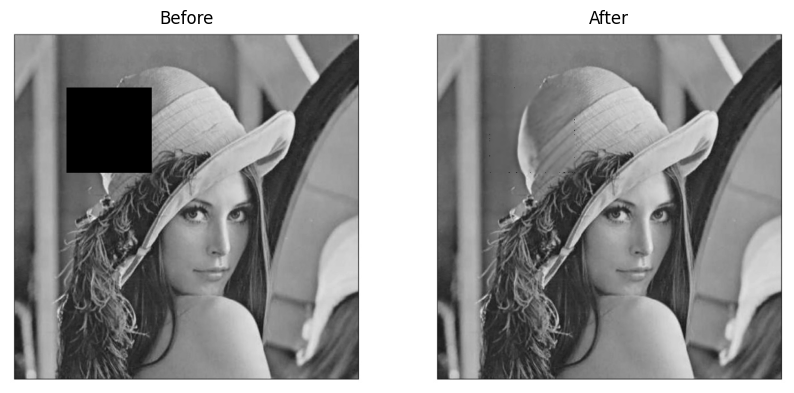

True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Load the original image
image_path = r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\known_region1.jpg"
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 

    # Load the inpainted image
image_path = r"C:\Users\VIET HOANG - VTS\Desktop\testoutput\known_region1.jpg"
inpainted_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Create a copy of the inpainted image for modification
inpainted_image = np.copy(inpainted_image)

    # Assuming inpainted_values are in the range expected by the image format, e.g., [0, 255] for uint8
    # If not, you might need to scale or adjust these values accordingly.
x = get_coordinates(smallest_region)
    # Populate the inpainted image with the predicted values
for (x, y), value in zip(x, inpainted_values):
    inpainted_image[x, y] = value

    # Display the original and inpainted images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Before')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(inpainted_image, cmap='gray')
plt.title('After')
plt.axis('off')

plt.show()
path_write = f"C:\\Users\\VIET HOANG - VTS\\Desktop\\testoutput\\inpainted99.jpg"
cv2.imwrite(path_write,inpainted_image)
    